# Adult Dataset: Calibration ver

In this notebook the optimal Deferral Net configuration is chosen, and the deferral tau threshold is calibrated.

Following the BRIDGET experimental pipeline, the Deferral Net is trained on the data predicted by the Human-in-Command process, then subsequently tested on the validation data to produce the optimal Tau deferral coefficient.

The architecture for the Nets to be tested are [(16, 8), (32, 16), (64, 32)].

The optimizer used is ADAM

The dropout rate was set to 0.2 to ensure the nets dont overfit initially, then tested up to 0.5



### Libraries and functions

In [128]:
# retrieving all libraries
%load_ext autoreload
%autoreload 2


from matplotlib import pyplot as plt

import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import metrics
from river import ensemble, linear_model, forest

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper


from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predictions')
    plt.ylabel('Ground Truths')
    plt.title('Confusion Matrix, DefNet')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

## Expert: Accurate, Trusting

In [11]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\Adult\calibration_datasets\acc_t_calibration")
df_val= df_val.rename(columns={'class': 'ground_truth'})  # per non confondermi


In [12]:
# retrieving data

df_acc_t = pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_accurate_trusting")

df_acc_t= df_acc_t.rename(columns={'class':'g_truth'})  

df_acc_t.to_csv(r".\processed_data\Adult\switch_ds\acc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [13]:
feat_order = [c for c in df_acc_t.columns if c not in [
    'class', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_acc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_t['g_truth'].values, dtype=torch.long)

acc_t_df = TensorDataset(X_cal, y_cal)
acc_t_loader = DataLoader(acc_t_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1


#### Net 1: 16/8

tau= 0.88

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
## instantiating def net

small_net= DeferralNet(input_size=12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0001,
                       weight_decay= 1e-4
                    )

weights = torch.tensor([1.0, 3.0]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)


##### Training

In [33]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\acc_t_models',
    filename_prefix='16_8_acc_t',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_t_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 1.40
Epoch[1], Iter[200] Loss: 0.91
Training Results - Epoch[1] Avg accuracy: 0.22 Avg loss: 0.76
Validation Results - Epoch[1] Avg accuracy: 0.28 Avg loss: 0.71
Epoch[2], Iter[300] Loss: 0.78
Epoch[2], Iter[400] Loss: 0.67
Training Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.62
Validation Results - Epoch[2] Avg accuracy: 0.77 Avg loss: 0.66
Epoch[3], Iter[500] Loss: 0.61
Epoch[3], Iter[600] Loss: 0.78
Epoch[3], Iter[700] Loss: 0.67
Training Results - Epoch[3] Avg accuracy: 0.84 Avg loss: 0.59
Validation Results - Epoch[3] Avg accuracy: 0.77 Avg loss: 0.64
Epoch[4], Iter[800] Loss: 0.70
Epoch[4], Iter[900] Loss: 0.55
Training Results - Epoch[4] Avg accuracy: 0.87 Avg loss: 0.56
Validation Results - Epoch[4] Avg accuracy: 0.79 Avg loss: 0.61
Epoch[5], Iter[1000] Loss: 0.78
Epoch[5], Iter[1100] Loss: 0.56
Training Results - Epoch[5] Avg accuracy: 0.88 Avg loss: 0.52
Validation Results - Epoch[5] Avg accuracy: 0.81 Avg loss: 0.59
Epoch[6], Iter[1200] Loss: 

State:
	iteration: 7080
	epoch: 30
	epoch_length: 236
	max_epochs: 30
	output: 0.3244718909263611
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

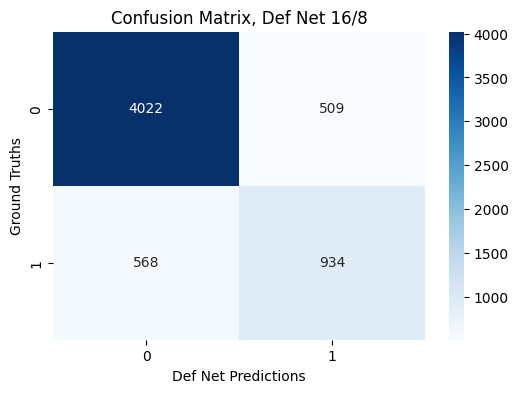

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4531
           1       0.65      0.62      0.63      1502

    accuracy                           0.82      6033
   macro avg       0.76      0.75      0.76      6033
weighted avg       0.82      0.82      0.82      6033



In [34]:
plot_confusion_matrix(small_net, val_loader, device)

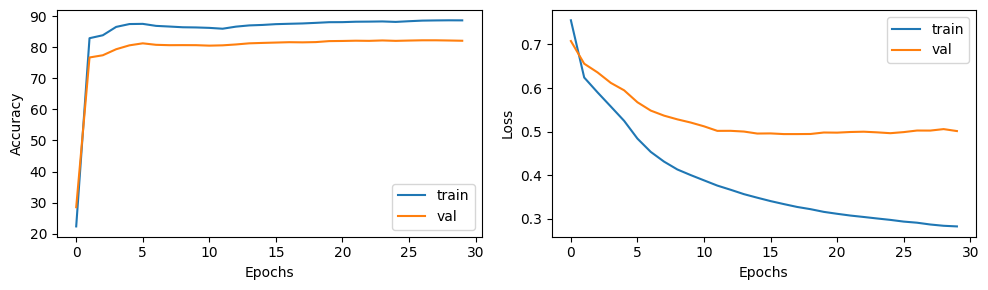

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [36]:
probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.88
0.9431567328918322


#### Net 2: 32/16

tau= 0.89

In [56]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 12, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-2
                    )
criterion= nn.CrossEntropyLoss()


##### Training

Epoch[1], Iter[100] Loss: 0.44
Epoch[1], Iter[200] Loss: 0.62
Training Results - Epoch[1] Avg accuracy: 0.82 Avg loss: 0.44
Validation Results - Epoch[1] Avg accuracy: 0.75 Avg loss: 0.51
Epoch[2], Iter[300] Loss: 0.36
Epoch[2], Iter[400] Loss: 0.37
Training Results - Epoch[2] Avg accuracy: 0.82 Avg loss: 0.35
Validation Results - Epoch[2] Avg accuracy: 0.75 Avg loss: 0.44
Epoch[3], Iter[500] Loss: 0.52
Epoch[3], Iter[600] Loss: 0.37
Epoch[3], Iter[700] Loss: 0.43
Training Results - Epoch[3] Avg accuracy: 0.87 Avg loss: 0.31
Validation Results - Epoch[3] Avg accuracy: 0.80 Avg loss: 0.42
Epoch[4], Iter[800] Loss: 0.34
Epoch[4], Iter[900] Loss: 0.30
Training Results - Epoch[4] Avg accuracy: 0.89 Avg loss: 0.28
Validation Results - Epoch[4] Avg accuracy: 0.81 Avg loss: 0.42
Epoch[5], Iter[1000] Loss: 0.29
Epoch[5], Iter[1100] Loss: 0.29
Training Results - Epoch[5] Avg accuracy: 0.90 Avg loss: 0.25
Validation Results - Epoch[5] Avg accuracy: 0.82 Avg loss: 0.41
Epoch[6], Iter[1200] Loss: 

2026-02-01 21:01:18,085 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[21] Avg accuracy: 0.92 Avg loss: 0.20
Validation Results - Epoch[21] Avg accuracy: 0.82 Avg loss: 0.40


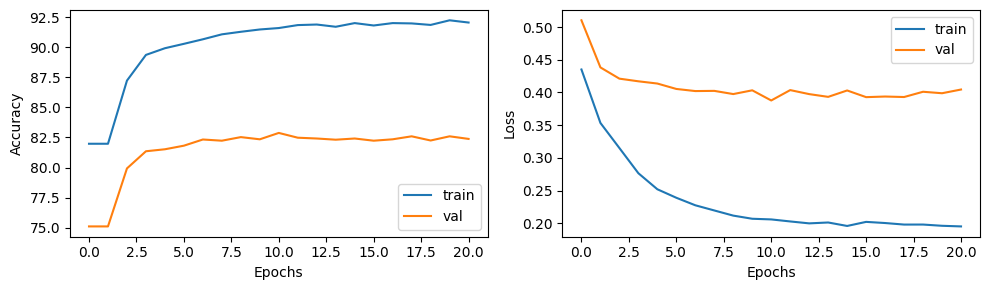

In [57]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'nets\Adult\acc_t_models',
    filename_prefix='32_16_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_t_loader, max_epochs= 30 )



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

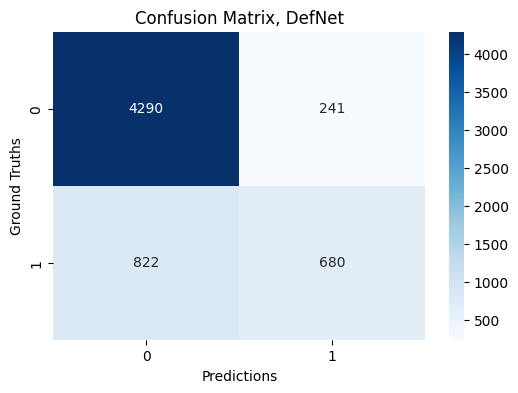

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4531
           1       0.74      0.45      0.56      1502

    accuracy                           0.82      6033
   macro avg       0.79      0.70      0.73      6033
weighted avg       0.81      0.82      0.81      6033



In [58]:
plot_confusion_matrix(large_net, val_loader, device)

##### Tau Threshold

In [59]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.89
0.9408268035666036


#### Net 3: 64/32

tau= 0.89199999999999999

In [60]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

net_3= DeferralNet(input_size= 12, hidden_layer1= 64, hidden_layer2= 32, output_size=2, dropout_coeff=0.2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_3.to(device)

optimizer = optim.Adam(params=net_3.parameters(), 
                       lr=0.0001,
                       weight_decay= 1e-4
                    )
criterion= nn.CrossEntropyLoss()


##### Training

Epoch[1], Iter[100] Loss: 0.47
Epoch[1], Iter[200] Loss: 0.66
Training Results - Epoch[1] Avg accuracy: 0.82 Avg loss: 0.43
Validation Results - Epoch[1] Avg accuracy: 0.75 Avg loss: 0.56
Epoch[2], Iter[300] Loss: 0.40
Epoch[2], Iter[400] Loss: 0.45
Training Results - Epoch[2] Avg accuracy: 0.82 Avg loss: 0.38
Validation Results - Epoch[2] Avg accuracy: 0.75 Avg loss: 0.50
Epoch[3], Iter[500] Loss: 0.50
Epoch[3], Iter[600] Loss: 0.53
Epoch[3], Iter[700] Loss: 0.45
Training Results - Epoch[3] Avg accuracy: 0.84 Avg loss: 0.34
Validation Results - Epoch[3] Avg accuracy: 0.76 Avg loss: 0.47
Epoch[4], Iter[800] Loss: 0.43
Epoch[4], Iter[900] Loss: 0.38
Training Results - Epoch[4] Avg accuracy: 0.87 Avg loss: 0.31
Validation Results - Epoch[4] Avg accuracy: 0.80 Avg loss: 0.44
Epoch[5], Iter[1000] Loss: 0.36
Epoch[5], Iter[1100] Loss: 0.37
Training Results - Epoch[5] Avg accuracy: 0.88 Avg loss: 0.29
Validation Results - Epoch[5] Avg accuracy: 0.81 Avg loss: 0.42
Epoch[6], Iter[1200] Loss: 

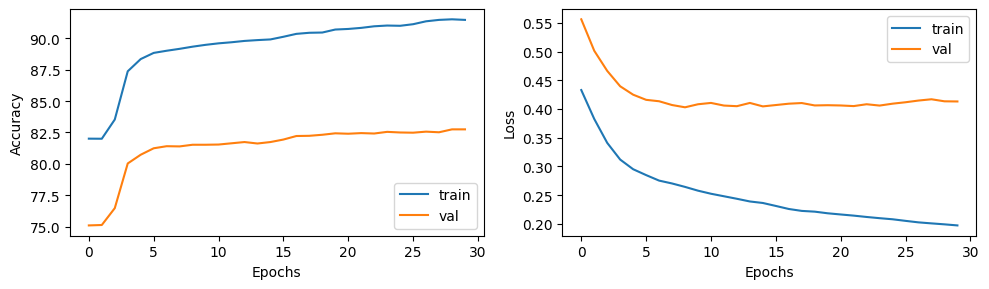

In [61]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(net_3, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(net_3, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(net_3, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'nets\Adult\acc_t_models',
    filename_prefix='64_32_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': net_3})


trainer.run(acc_t_loader, max_epochs= 30 )



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

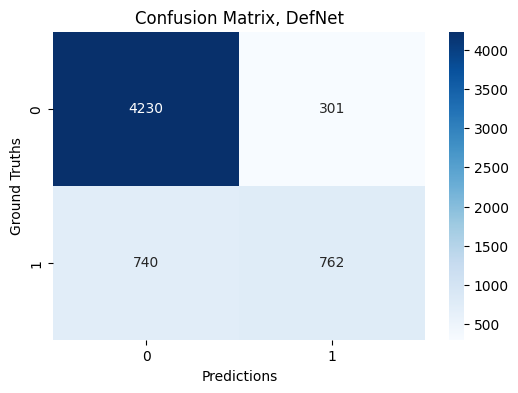

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4531
           1       0.72      0.51      0.59      1502

    accuracy                           0.83      6033
   macro avg       0.78      0.72      0.74      6033
weighted avg       0.82      0.83      0.82      6033



In [62]:
plot_confusion_matrix(net_3, val_loader, device)

##### Tau Threshold

In [63]:
# dopo avere scelto la net migliore

probas= net_3.predict_proba_nn(X_val, device)
y_pred= net_3.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.9199999999999999
0.9441431670281996


### Deferral Strat 2 (anqi mao style) con la rete 1

one of these:

0.197959 (tau_r)       0.906770 (acc)      0.115709 (def rate)

0.214286       0.896559       0.081029

altho 10% deferral is a lot

In [64]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [66]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.3)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-4)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [67]:
save_dir = r'.\r_nets\Adult'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 1.5285
Epoch 2/20 - Loss: 0.9825
Epoch 3/20 - Loss: 0.6777
Epoch 4/20 - Loss: 0.5328
Epoch 5/20 - Loss: 0.5007
Epoch 6/20 - Loss: 0.4930
Epoch 7/20 - Loss: 0.4874
Epoch 8/20 - Loss: 0.4800
Epoch 9/20 - Loss: 0.4756
Epoch 10/20 - Loss: 0.4729
Epoch 11/20 - Loss: 0.4680
Epoch 12/20 - Loss: 0.4635
Epoch 13/20 - Loss: 0.4624
Epoch 14/20 - Loss: 0.4601
Epoch 15/20 - Loss: 0.4608
Epoch 16/20 - Loss: 0.4573
Epoch 17/20 - Loss: 0.4552
Epoch 18/20 - Loss: 0.4522
Epoch 19/20 - Loss: 0.4546
Epoch 20/20 - Loss: 0.4504
✅ r_net salvata correttamente in .\r_nets\Adult


In [69]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.4)

net_path= r".\nets\Adult\acc_t_models\16_8_acc_t_model_30.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.9, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       0.999668
1   0.116327       1.000000       0.998939
2   0.132653       1.000000       0.993170
3   0.148980       0.999470       0.928254
4   0.165306       0.988064       0.686957
5   0.181633       0.946091       0.327896
6   0.197959       0.906770       0.115709
7   0.214286       0.896559       0.081029
8   0.230612       0.895895       0.074531
9   0.246939       0.895630       0.066905
10  0.263265       0.895033       0.059346
11  0.279592       0.894636       0.051124
12  0.295918       0.893442       0.039188
13  0.312245       0.892646       0.030303
14  0.328571       0.891453       0.022479
15  0.344898       0.890458       0.015715
16  0.361224       0.889928       0.011272
17  0.377551       0.889066       0.007228
18  0.393878       0.888469       0.003846
19  0.410204       0.887872       0.001525
20  0.426531       0.887474       0.000265
21  0.442857       0.887275       0.000066
22  0.45918

## Expert: Inaccurate, Trusting

In [114]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\Adult\calibration_datasets\inacc_t_calibration")
df_val= df_val.rename(columns={'class': 'ground_truth'})  # per non confondermi


In [115]:
# dropping irrelevant feat + renaming the decision column as 'ground truth' 
df_inacc_t= pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_inaccurate_trusting")

df_inacc_t= df_inacc_t.rename(columns={'class':'g_truth'})  

df_inacc_t.to_csv(r".\processed_data\Adult\switch_ds\inacc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch


In [116]:
feat_order = [c for c in df_inacc_t.columns if c not in [
    'class', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_inacc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_t['g_truth'].values, dtype=torch.long)

inacc_t_df = TensorDataset(X_cal, y_cal)
inacc_t_loader = DataLoader(inacc_t_df, batch_size=32, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Strat 1

tau= 0.81

#### Net 1

In [133]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.1)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.001,
                       weight_decay= 1e-2,
                    )

weights = torch.tensor([1.0, 1.5]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [134]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\inacc_t_models',
    filename_prefix='16_8',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_t_loader, max_epochs= 50)

Epoch[1], Iter[100] Loss: 0.48
Epoch[1], Iter[200] Loss: 0.50
Epoch[1], Iter[300] Loss: 0.56
Epoch[1], Iter[400] Loss: 0.63
Training Results - Epoch[1] Avg accuracy: 0.79 Avg loss: 0.43
Validation Results - Epoch[1] Avg accuracy: 0.62 Avg loss: 0.65
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[500] Loss: 0.31
Epoch[2], Iter[600] Loss: 0.55
Epoch[2], Iter[700] Loss: 0.43
Epoch[2], Iter[800] Loss: 0.40
Epoch[2], Iter[900] Loss: 0.47
Training Results - Epoch[2] Avg accuracy: 0.79 Avg loss: 0.40
Validation Results - Epoch[2] Avg accuracy: 0.63 Avg loss: 0.65
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[1000] Loss: 0.31
Epoch[3], Iter[1100] Loss: 0.25
Epoch[3], Iter[1200] Loss: 0.24
Epoch[3], Iter[1300] Loss: 0.29
Epoch[3], Iter[1400] Loss: 0.48
Training Results - Epoch[3] Avg accuracy: 0.80 Avg loss: 0.39
Validation Results - Epoch[3] Avg accuracy: 0.64 Avg loss: 0.64
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[1500] Loss: 0.21
Epoch[4], Iter[1600] Loss: 0.25
Epoch[4], I

2026-02-02 10:53:32,494 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[25] Avg accuracy: 0.84 Avg loss: 0.33
Validation Results - Epoch[25] Avg accuracy: 0.67 Avg loss: 0.70
End of Epoch 25: Learning Rate 0.000125


State:
	iteration: 11800
	epoch: 25
	epoch_length: 472
	max_epochs: 50
	output: 0.15243934094905853
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

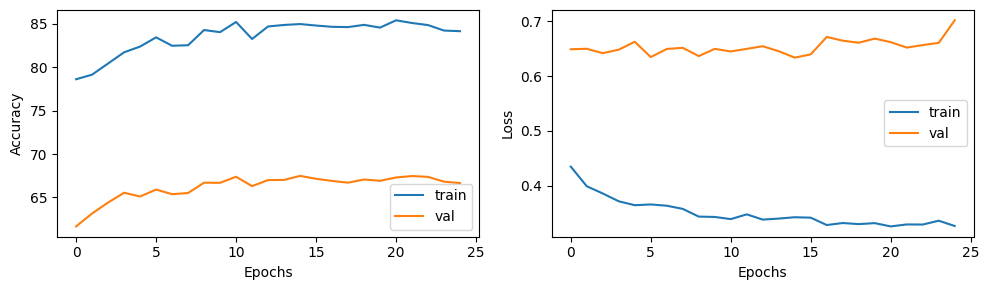

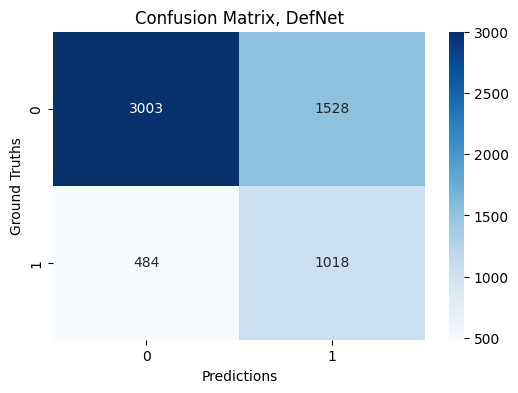

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      4531
           1       0.40      0.68      0.50      1502

    accuracy                           0.67      6033
   macro avg       0.63      0.67      0.63      6033
weighted avg       0.75      0.67      0.69      6033



In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [137]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.81
0.7400544959128066


#### Net 2: 32/16

In [140]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 12, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.1)

optimizer= optim.Adam(large_net.parameters(), 
                      lr=0.001, 
                      weight_decay=1e-3)

weights = torch.tensor([1.0, 1.5]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.47
Epoch[1], Iter[200] Loss: 0.38
Epoch[1], Iter[300] Loss: 0.38
Epoch[1], Iter[400] Loss: 0.55
Training Results - Epoch[1] Avg accuracy: 0.79 Avg loss: 0.40
Validation Results - Epoch[1] Avg accuracy: 0.63 Avg loss: 0.66
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[500] Loss: 0.35
Epoch[2], Iter[600] Loss: 0.47
Epoch[2], Iter[700] Loss: 0.31
Epoch[2], Iter[800] Loss: 0.39
Epoch[2], Iter[900] Loss: 0.45
Training Results - Epoch[2] Avg accuracy: 0.78 Avg loss: 0.40
Validation Results - Epoch[2] Avg accuracy: 0.63 Avg loss: 0.65
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[1000] Loss: 0.29
Epoch[3], Iter[1100] Loss: 0.20
Epoch[3], Iter[1200] Loss: 0.24
Epoch[3], Iter[1300] Loss: 0.41
Epoch[3], Iter[1400] Loss: 0.41
Training Results - Epoch[3] Avg accuracy: 0.81 Avg loss: 0.37
Validation Results - Epoch[3] Avg accuracy: 0.65 Avg loss: 0.65
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[1500] Loss: 0.21
Epoch[4], Iter[1600] Loss: 0.23
Epoch[4], I

2026-02-02 11:02:04,931 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[22] Avg accuracy: 0.85 Avg loss: 0.31
Validation Results - Epoch[22] Avg accuracy: 0.67 Avg loss: 0.73
End of Epoch 22: Learning Rate 0.00025


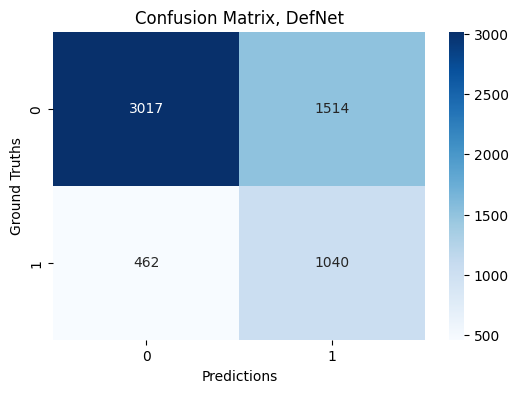

              precision    recall  f1-score   support

           0       0.87      0.67      0.75      4531
           1       0.41      0.69      0.51      1502

    accuracy                           0.67      6033
   macro avg       0.64      0.68      0.63      6033
weighted avg       0.75      0.67      0.69      6033



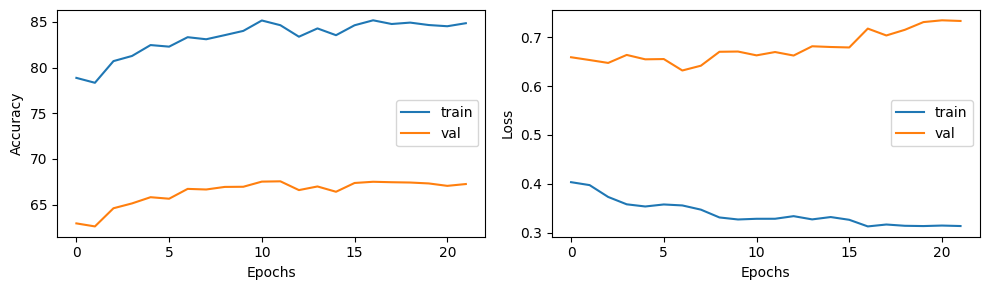

In [141]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\inacc_t_models',
    filename_prefix='32_16',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_t_loader, max_epochs= 50)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [143]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.78
0.7434924078091106


### Deferral Strat 2 (anqi mao style)

i papabili

tau r            acc           def rate

0.204082       0.849877       0.080101

0.224490       0.846695       0.072011

0.244898       0.845634       0.064784

In [144]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [145]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.1)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")

torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.4430
Epoch 2/20 - Loss: 0.3843
Epoch 3/20 - Loss: 0.3779
Epoch 4/20 - Loss: 0.3750
Epoch 5/20 - Loss: 0.3735
Epoch 6/20 - Loss: 0.3704
Epoch 7/20 - Loss: 0.3693
Epoch 8/20 - Loss: 0.3674
Epoch 9/20 - Loss: 0.3673
Epoch 10/20 - Loss: 0.3664
Epoch 11/20 - Loss: 0.3654
Epoch 12/20 - Loss: 0.3656
Epoch 13/20 - Loss: 0.3647
Epoch 14/20 - Loss: 0.3644
Epoch 15/20 - Loss: 0.3645
Epoch 16/20 - Loss: 0.3640
Epoch 17/20 - Loss: 0.3638
Epoch 18/20 - Loss: 0.3638
Epoch 19/20 - Loss: 0.3636
Epoch 20/20 - Loss: 0.3636
✅ r_net salvata correttamente in .\r_nets\Adult


In [146]:
#richiamo la net 
small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.1)

net_path= r".\nets\Adult\inacc_t_models\16_8_model_25.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 1.0, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.020408       1.000000       1.000000
2   0.040816       1.000000       1.000000
3   0.061224       1.000000       1.000000
4   0.081633       0.999934       0.997414
5   0.102041       0.999934       0.969697
6   0.122449       0.999602       0.888137
7   0.142857       0.995756       0.734301
8   0.163265       0.948677       0.456734
9   0.183673       0.878191       0.191168
10  0.204082       0.849877       0.080101
11  0.224490       0.846695       0.072011
12  0.244898       0.845634       0.064784
13  0.265306       0.844175       0.055832
14  0.285714       0.842915       0.045488
15  0.306122       0.842318       0.031032
16  0.326531       0.842119       0.016776
17  0.346939       0.841788       0.005305
18  0.367347       0.841456       0.000000
19  0.387755       0.841456       0.000000
20  0.408163       0.841456       0.000000
21  0.428571       0.841456       0.000000
22  0.44898

## Expert: Accurate, Not Trusting

In [147]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\Adult\calibration_datasets\acc_nt_calibration")
df_val= df_val.rename(columns={'class': 'ground_truth'})  # per non confondermi

In [148]:
# retrieving data

df_acc_nt = pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_accurate_not_trusting")


df_acc_nt= df_acc_nt.rename(columns={'class':'g_truth'})  

df_acc_nt.to_csv(r".\processed_data\Adult\switch_ds\acc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch
df_acc_nt


,relationship,workclass,native-country,sex,occupation,race,marital-status,education-num,age,capital-loss,capital-gain,hours-per-week,expert prediction,machine prediction,ground truth,proba_model,g_truth,provider
0,4,4,41,1,14,1,2,-0.035458,-0.742616,-0.216178,-0.134207,-0.065588,0,0,0,0.953091,0,H
1,1,2,41,0,14,1,1,1.141478,0.646147,-0.216170,0.892133,-0.065586,1,1,1,0.857182,1,H
2,5,2,41,0,7,1,7,-0.427857,-1.359796,-0.216162,-0.134265,-0.065584,0,0,0,0.974688,0,H
3,3,2,41,1,5,1,7,-0.427840,-0.588223,-0.216154,-0.134260,-0.065581,0,0,0,0.989375,0,H
4,5,2,41,0,10,1,7,-0.427822,-0.973939,-0.216147,-0.134256,-0.065579,0,0,0,0.977943,0,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,4,2,41,1,10,1,2,-0.436029,-0.654916,-0.218980,-0.142597,-0.068606,0,0,0,0.911020,0,H
15077,1,4,41,0,14,2,1,-0.436020,0.877947,-0.218976,-0.142595,-0.068604,0,0,0,0.767597,0,H
15078,5,2,41,1,5,1,7,-0.043191,-0.578291,-0.218972,-0.142592,1.603267,0,0,0,0.948644,0,H
15079,4,2,41,1,4,2,7,-2.007199,0.954592,-0.218968,-0.142590,-0.068656,0,0,0,0.968450,0,H


In [196]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'class', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_acc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_nt['g_truth'].values, dtype=torch.long)

acc_nt_df = TensorDataset(X_cal, y_cal)
acc_nt_loader = DataLoader(acc_nt_df, batch_size=32, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Confidence Based Deferral

#### Net 1 16/8

In [201]:
small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.1)


optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.0005,
                       weight_decay= 1e-2,
                    )


weights = torch.tensor([1.0, 1.5]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)


scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [202]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\acc_nt_models',
    filename_prefix='16_8_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty= False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_nt_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 0.58
Epoch[1], Iter[200] Loss: 0.49
Epoch[1], Iter[300] Loss: 0.42
Epoch[1], Iter[400] Loss: 0.66
Training Results - Epoch[1] Avg accuracy: 0.90 Avg loss: 0.35
Validation Results - Epoch[1] Avg accuracy: 0.81 Avg loss: 0.47
End of Epoch 1: Learning Rate 0.0005
Epoch[2], Iter[500] Loss: 0.41
Epoch[2], Iter[600] Loss: 0.18
Epoch[2], Iter[700] Loss: 0.34
Epoch[2], Iter[800] Loss: 0.22
Epoch[2], Iter[900] Loss: 0.31
Training Results - Epoch[2] Avg accuracy: 0.91 Avg loss: 0.26
Validation Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.44
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[1000] Loss: 0.31
Epoch[3], Iter[1100] Loss: 0.28
Epoch[3], Iter[1200] Loss: 0.17
Epoch[3], Iter[1300] Loss: 0.31
Epoch[3], Iter[1400] Loss: 0.22
Training Results - Epoch[3] Avg accuracy: 0.91 Avg loss: 0.26
Validation Results - Epoch[3] Avg accuracy: 0.83 Avg loss: 0.42
End of Epoch 3: Learning Rate 0.0005
Epoch[4], Iter[1500] Loss: 0.32
Epoch[4], Iter[1600] Loss: 0.27
Epoch[4]

2026-02-02 11:47:15,149 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[23] Avg accuracy: 0.92 Avg loss: 0.21
Validation Results - Epoch[23] Avg accuracy: 0.83 Avg loss: 0.45
End of Epoch 23: Learning Rate 0.000125


State:
	iteration: 10856
	epoch: 23
	epoch_length: 472
	max_epochs: 30
	output: 0.11301692575216293
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

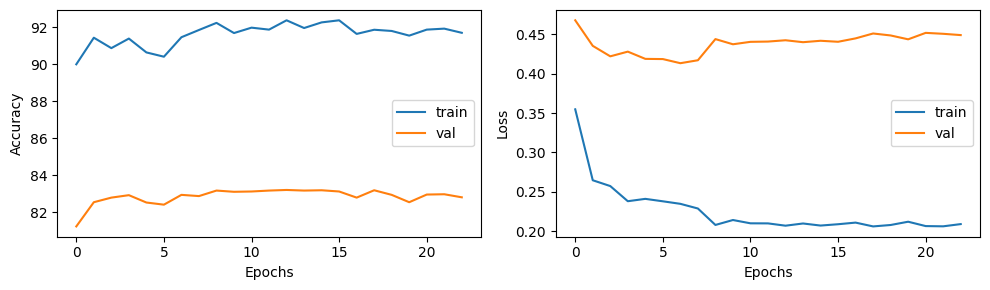

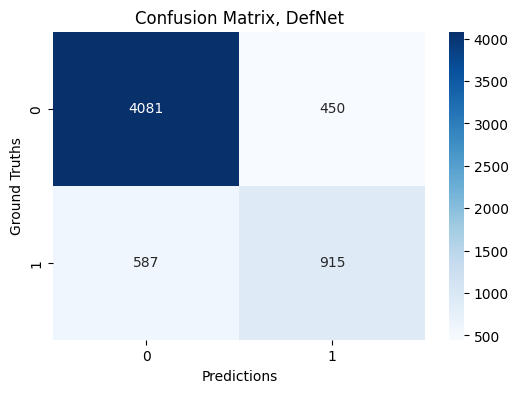

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4531
           1       0.67      0.61      0.64      1502

    accuracy                           0.83      6033
   macro avg       0.77      0.75      0.76      6033
weighted avg       0.82      0.83      0.83      6033



In [203]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [204]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.9
0.9472551130247578


#### Net 2 32/16

In [206]:
large_net= DeferralNet(input_size= 12, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

optimizer= optim.Adam(large_net.parameters(), 
                      lr=0.0005, 
                      weight_decay=1e-2)

weights = torch.tensor([1.0, 1.2]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)


scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.49
Epoch[1], Iter[200] Loss: 0.45
Epoch[1], Iter[300] Loss: 0.41
Epoch[1], Iter[400] Loss: 0.57
Training Results - Epoch[1] Avg accuracy: 0.90 Avg loss: 0.31
Validation Results - Epoch[1] Avg accuracy: 0.81 Avg loss: 0.43
End of Epoch 1: Learning Rate 0.0005
Epoch[2], Iter[500] Loss: 0.42
Epoch[2], Iter[600] Loss: 0.21
Epoch[2], Iter[700] Loss: 0.36
Epoch[2], Iter[800] Loss: 0.23
Epoch[2], Iter[900] Loss: 0.27
Training Results - Epoch[2] Avg accuracy: 0.91 Avg loss: 0.26
Validation Results - Epoch[2] Avg accuracy: 0.82 Avg loss: 0.41
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[1000] Loss: 0.34
Epoch[3], Iter[1100] Loss: 0.42
Epoch[3], Iter[1200] Loss: 0.26
Epoch[3], Iter[1300] Loss: 0.22
Epoch[3], Iter[1400] Loss: 0.25
Training Results - Epoch[3] Avg accuracy: 0.91 Avg loss: 0.24
Validation Results - Epoch[3] Avg accuracy: 0.83 Avg loss: 0.41
End of Epoch 3: Learning Rate 0.0005
Epoch[4], Iter[1500] Loss: 0.29
Epoch[4], Iter[1600] Loss: 0.23
Epoch[4]

2026-02-02 11:48:42,014 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[18] Avg accuracy: 0.93 Avg loss: 0.19
Validation Results - Epoch[18] Avg accuracy: 0.83 Avg loss: 0.42
End of Epoch 18: Learning Rate 0.000125


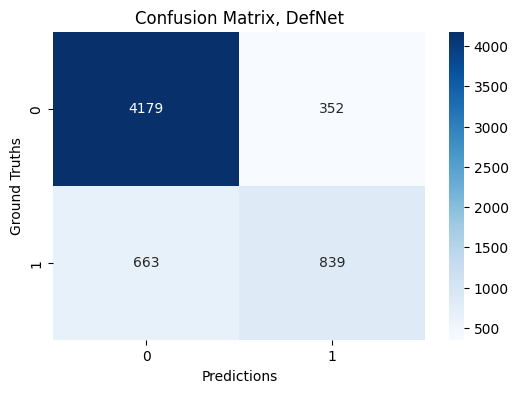

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4531
           1       0.70      0.56      0.62      1502

    accuracy                           0.83      6033
   macro avg       0.78      0.74      0.76      6033
weighted avg       0.82      0.83      0.82      6033



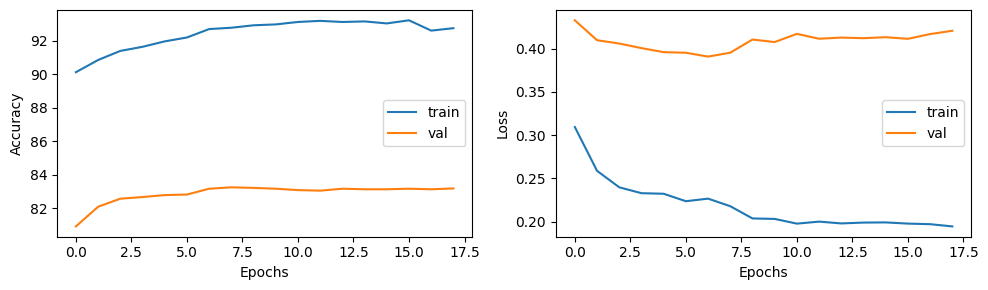

In [207]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\acc_nt_models',
    filename_prefix='32_16_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_nt_loader, max_epochs= 40)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [208]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.9
0.9501514734232994


### Anqi Mao style Deferral

papabili

  0.173469       0.922684       0.107287

  0.181633       0.919899       0.049864   questa meglio

  0.189796       0.918971       0.023407

In [209]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [210]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.1)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) 
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.4262
Epoch 2/20 - Loss: 0.4038
Epoch 3/20 - Loss: 0.4021
Epoch 4/20 - Loss: 0.4006
Epoch 5/20 - Loss: 0.4001
Epoch 6/20 - Loss: 0.3995
Epoch 7/20 - Loss: 0.3995
Epoch 8/20 - Loss: 0.3985
Epoch 9/20 - Loss: 0.3981
Epoch 10/20 - Loss: 0.3978
Epoch 11/20 - Loss: 0.3975
Epoch 12/20 - Loss: 0.3976
Epoch 13/20 - Loss: 0.3975
Epoch 14/20 - Loss: 0.3972
Epoch 15/20 - Loss: 0.3964
Epoch 16/20 - Loss: 0.3961
Epoch 17/20 - Loss: 0.3966
Epoch 18/20 - Loss: 0.3961
Epoch 19/20 - Loss: 0.3960
Epoch 20/20 - Loss: 0.3957
✅ r_net salvata correttamente in .\r_nets\Adult


In [212]:
#richiamo la net 
small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.1)

net_path= r".\nets\Adult\acc_nt_models\16_8_acc_nt_model_23.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       0.946754
1   0.108163       0.999668       0.906041
2   0.116327       0.998806       0.852066
3   0.124490       0.995690       0.777734
4   0.132653       0.984086       0.668391
5   0.140816       0.967111       0.544858
6   0.148980       0.951993       0.430277
7   0.157143       0.940985       0.325244
8   0.165306       0.929315       0.212519
9   0.173469       0.922684       0.107287
10  0.181633       0.919899       0.049864
11  0.189796       0.918971       0.023407
12  0.197959       0.918639       0.020290
13  0.206122       0.918573       0.017240
14  0.214286       0.918374       0.014853
15  0.222449       0.918175       0.012996
16  0.230612       0.918043       0.011206
17  0.238776       0.917910       0.009217
18  0.246939       0.917711       0.007559
19  0.255102       0.917578       0.005901
20  0.263265       0.917512       0.004774
21  0.271429       0.917379       0.003713
22  0.27959

## Expert: Inaccurate, Not Trusting

In [ ]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\Adult\calibration_datasets\inacc_nt_calibration")
df_val= df_val.rename(columns={'class': 'ground_truth'})  # per non confondermi

In [213]:
# retrieving data

df_inacc_nt = pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_inaccurate_not_trusting")
df_inacc_nt.head(n=5)

df_inacc_nt= df_inacc_nt.rename(columns={'class':'g_truth'})  

df_inacc_nt.to_csv(r".\processed_data\Adult\switch_ds\inacc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [214]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'class', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_inacc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_nt['g_truth'].values, dtype=torch.long)

inacc_nt_df = TensorDataset(X_cal, y_cal)
inacc_nt_loader = DataLoader(inacc_nt_df, batch_size=64, shuffle=False)


X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1

#### Net 1

In [259]:
small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, 
                       output_size=2, dropout_coeff=0.4)

optimizer= optim.Adam(small_net.parameters(), 
                      lr=0.0005, 
                      weight_decay=5e-2)

weights = torch.tensor([1.0, 1.5]).to(device)

criterion= nn.CrossEntropyLoss(weight=weights)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [260]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\inacc_nt_models',
    filename_prefix='16_8_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_nt_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 0.73
Epoch[1], Iter[200] Loss: 0.71
Training Results - Epoch[1] Avg accuracy: 0.67 Avg loss: 0.66
Validation Results - Epoch[1] Avg accuracy: 0.75 Avg loss: 0.66
End of Epoch 1: Learning Rate 0.0005
Epoch[2], Iter[300] Loss: 0.68
Epoch[2], Iter[400] Loss: 0.63
Training Results - Epoch[2] Avg accuracy: 0.80 Avg loss: 0.60
Validation Results - Epoch[2] Avg accuracy: 0.59 Avg loss: 0.67
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[500] Loss: 0.62
Epoch[3], Iter[600] Loss: 0.58
Epoch[3], Iter[700] Loss: 0.61
Training Results - Epoch[3] Avg accuracy: 0.79 Avg loss: 0.53
Validation Results - Epoch[3] Avg accuracy: 0.57 Avg loss: 0.67
End of Epoch 3: Learning Rate 0.0005
Epoch[4], Iter[800] Loss: 0.56
Epoch[4], Iter[900] Loss: 0.54
Training Results - Epoch[4] Avg accuracy: 0.79 Avg loss: 0.50
Validation Results - Epoch[4] Avg accuracy: 0.57 Avg loss: 0.66
End of Epoch 4: Learning Rate 0.0005
Epoch[5], Iter[1000] Loss: 0.51
Epoch[5], Iter[1100] Loss: 0.56
Train

2026-02-02 12:16:00,355 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[11] Avg accuracy: 0.82 Avg loss: 0.43
Validation Results - Epoch[11] Avg accuracy: 0.60 Avg loss: 0.66
End of Epoch 11: Learning Rate 0.00025


State:
	iteration: 2596
	epoch: 11
	epoch_length: 236
	max_epochs: 30
	output: 0.5553027391433716
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

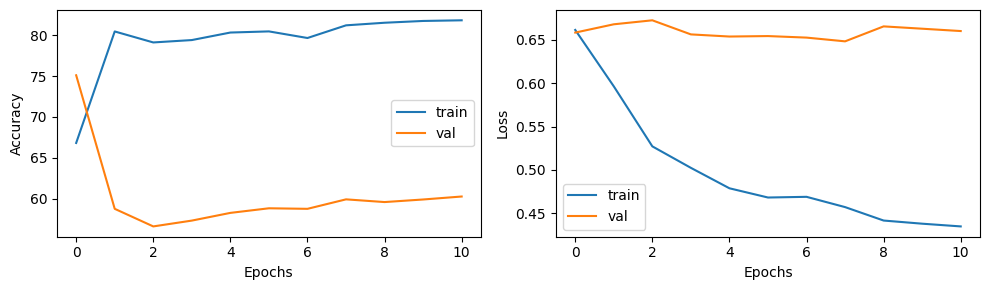

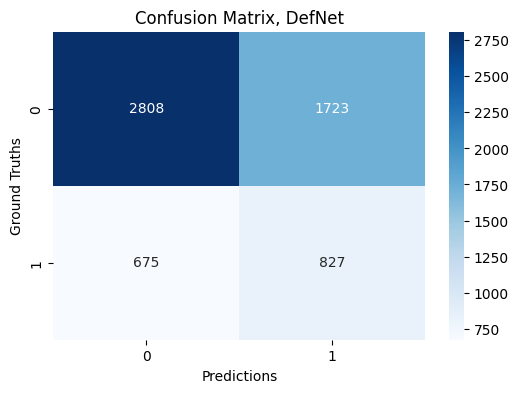

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      4531
           1       0.32      0.55      0.41      1502

    accuracy                           0.60      6033
   macro avg       0.57      0.59      0.55      6033
weighted avg       0.69      0.60      0.63      6033



In [261]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [265]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.69
0.6852106857614982


#### Net 2

In [263]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 12, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.4)

optimizer= optim.Adam(large_net.parameters(), 
                      lr=0.0005, 
                      weight_decay=5e-2)

weights = torch.tensor([1.0, 1.5]).to(device)

criterion= nn.CrossEntropyLoss(weight=weights)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.71
Epoch[1], Iter[200] Loss: 0.67
Training Results - Epoch[1] Avg accuracy: 0.75 Avg loss: 0.66
Validation Results - Epoch[1] Avg accuracy: 0.55 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.0005
Epoch[2], Iter[300] Loss: 0.66
Epoch[2], Iter[400] Loss: 0.54
Training Results - Epoch[2] Avg accuracy: 0.79 Avg loss: 0.54
Validation Results - Epoch[2] Avg accuracy: 0.55 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[500] Loss: 0.60
Epoch[3], Iter[600] Loss: 0.44
Epoch[3], Iter[700] Loss: 0.64
Training Results - Epoch[3] Avg accuracy: 0.79 Avg loss: 0.49
Validation Results - Epoch[3] Avg accuracy: 0.57 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.0005
Epoch[4], Iter[800] Loss: 0.50
Epoch[4], Iter[900] Loss: 0.51
Training Results - Epoch[4] Avg accuracy: 0.80 Avg loss: 0.46
Validation Results - Epoch[4] Avg accuracy: 0.58 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.0005
Epoch[5], Iter[1000] Loss: 0.54
Epoch[5], Iter[1100] Loss: 0.46
Train

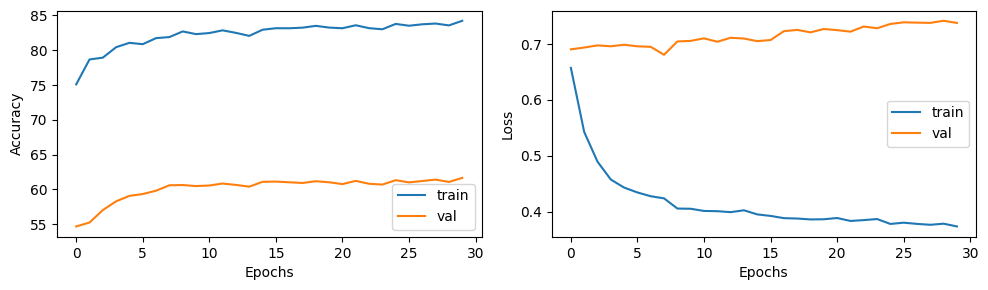

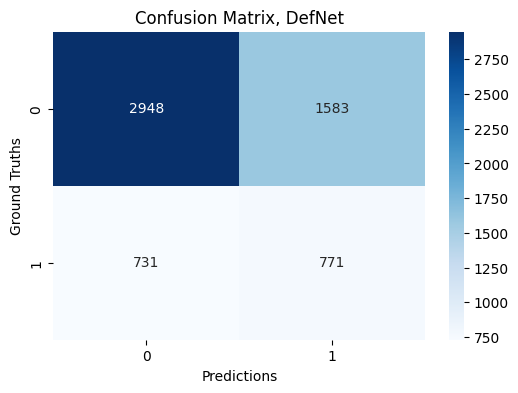

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      4531
           1       0.33      0.51      0.40      1502

    accuracy                           0.62      6033
   macro avg       0.56      0.58      0.56      6033
weighted avg       0.68      0.62      0.64      6033



In [264]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\Adult\inacc_nt_models',
    filename_prefix='32_16_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_nt_loader, max_epochs= 30)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)

##### Tau Threshold

In [266]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.78
0.6801089918256131


### Anqi Mao Strat


papabili


  0.173469       0.854585       0.215702

  0.183673       0.839865       0.149526

  0.193878       0.828393       0.068629  <--

  0.204082       0.822691       0.021285

In [267]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)



In [269]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.4)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()


Epoch 1/20 - Loss: 0.4197
Epoch 2/20 - Loss: 0.3901
Epoch 3/20 - Loss: 0.3800
Epoch 4/20 - Loss: 0.3724
Epoch 5/20 - Loss: 0.3690
Epoch 6/20 - Loss: 0.3653
Epoch 7/20 - Loss: 0.3642
Epoch 8/20 - Loss: 0.3635
Epoch 9/20 - Loss: 0.3625
Epoch 10/20 - Loss: 0.3622
Epoch 11/20 - Loss: 0.3617
Epoch 12/20 - Loss: 0.3614
Epoch 13/20 - Loss: 0.3611
Epoch 14/20 - Loss: 0.3608
Epoch 15/20 - Loss: 0.3606
Epoch 16/20 - Loss: 0.3609
Epoch 17/20 - Loss: 0.3607
Epoch 18/20 - Loss: 0.3610
Epoch 19/20 - Loss: 0.3606
Epoch 20/20 - Loss: 0.3606
✅ r_net salvata correttamente in .\r_nets\Adult


In [270]:
#richiamo la net 
small_net= DeferralNet(input_size= 12, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.5)

net_path= r"nets\Adult\inacc_nt_models\16_8_inacc_nt_model_11.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.010204       1.000000       1.000000
2   0.020408       1.000000       1.000000
3   0.030612       1.000000       1.000000
4   0.040816       1.000000       1.000000
5   0.051020       1.000000       1.000000
6   0.061224       1.000000       0.999867
7   0.071429       1.000000       0.999801
8   0.081633       1.000000       0.999403
9   0.091837       1.000000       0.997746
10  0.102041       0.999867       0.988595
11  0.112245       0.999735       0.965055
12  0.122449       0.998276       0.920562
13  0.132653       0.994231       0.840528
14  0.142857       0.984417       0.720509
15  0.153061       0.949075       0.561965
16  0.163265       0.903322       0.382004
17  0.173469       0.854585       0.215702
18  0.183673       0.839865       0.149526
19  0.193878       0.828393       0.068629
20  0.204082       0.822691       0.021285
21  0.214286       0.819972       0.014389
22  0.22449